#### Graph measures

This script showcases how to use some graph measures included in the comet toolbox.


In [6]:
import bct
import numpy as np
from nilearn import datasets
from matplotlib import pyplot as plt
from comet import graph
import networkx as nx
import time

# Get preprocessed time series data from the ABIDE dataset
subjects = [50008, 50010, 50012, 50014]
data = datasets.fetch_abide_pcp(SUB_ID=subjects, pipeline='cpac', band_pass_filtering=True, derivatives="rois_dosenbach160", legacy_format=False)

#### Calculate and plot static functional connectivity

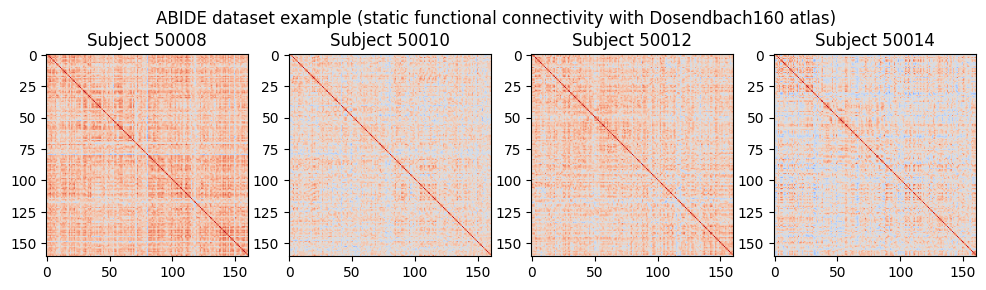

In [7]:
fig, ax = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('ABIDE dataset example (static functional connectivity with Dosendbach160 atlas)')

fc = []
for sub in range(len(subjects)):
    ts = data.rois_dosenbach160[sub]
    corr = np.corrcoef(ts.T)
    fc.append(corr)
    ax[sub].imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    ax[sub].set_title('Subject %d' % subjects[sub])

#### Graph construction and plotting of the resulting adjacency matrices

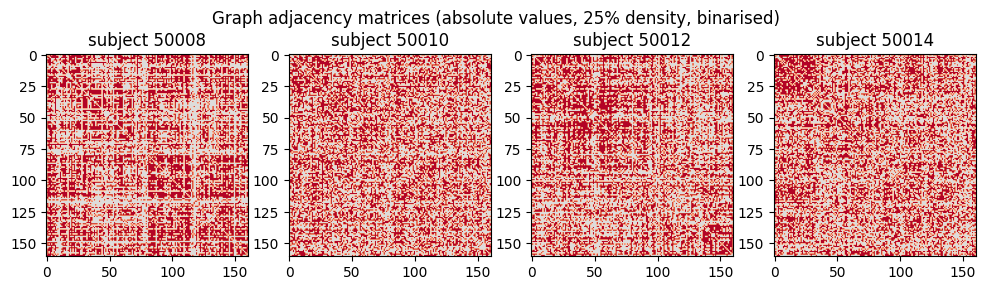

In [8]:
fig, ax = plt.subplots(1,4, figsize=(12,3))
fig.suptitle('Graph adjacency matrices (absolute values, 25% density, binarised)')

G = []
for i, sub in enumerate(subjects):
    g = graph.handle_negative_weights(fc[i], type="absolute")
    g = graph.threshold(g, type="density", density=0.5)
    g = graph.binarise(g)
    ax[i].imshow(g, cmap='coolwarm', vmin=-1, vmax=1)
    ax[i].set_title(f"subject {sub}")
    G.append(g)

#### Calculate small-world sigma

In [9]:
for i, sub in enumerate(subjects):
    sigma = graph.small_world_sigma(G[i], nrand=10)
    print(f"Subject {sub} small-world sigma: {sigma:.2f}")

Subject 50008 small-world sigma: 1.35
Subject 50010 small-world sigma: 1.11
Subject 50012 small-world sigma: 1.22
Subject 50014 small-world sigma: 1.11


Do some benchmarking:

Time networkx: [2.4591522216796875, 12.499826431274414, 36.66972374916077, 86.32696151733398]
Time comet: [0.0033407211303710938, 0.0038917064666748047, 0.007163524627685547, 0.014304399490356445]


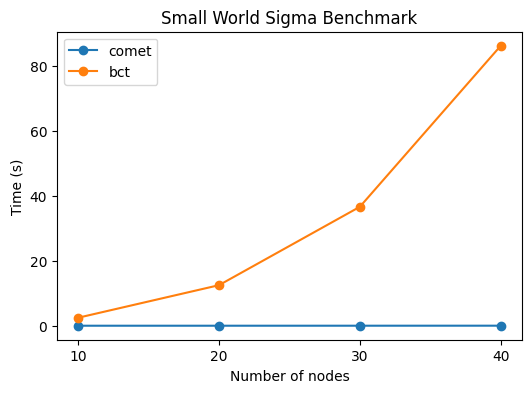

In [10]:
adj = fc[0]

nodes = [10, 20, 30, 40]
comet = []
netx = []

W = adj[:5, :5]
WG = nx.from_numpy_array(W)
sigma_nx = nx.sigma(WG, nrand=10)
sigma_comet = graph.small_world_sigma(W, nrand=10)

for i in nodes:
    W = adj[:i, :i]
    WG = nx.from_numpy_array(W)
    start = time.time()
    sigma_nx = nx.sigma(WG, nrand=10)
    netx.append(time.time() - start)

    start = time.time()
    sigma_comet = graph.small_world_sigma(W, nrand=10)
    comet.append(time.time() - start)

print(f"Time networkx: {netx}")
print(f"Time comet: {comet}")

# Plot the results
plt.figure(figsize=(6,4))
plt.title('Small World Sigma Benchmark')
plt.plot(nodes, comet, label="comet", marker='o')
plt.plot(nodes, netx, label="bct", marker='o')
plt.xlabel('Number of nodes')
plt.xticks(nodes)
plt.ylabel('Time (s)')
plt.legend();

#### Calculate local efficiency

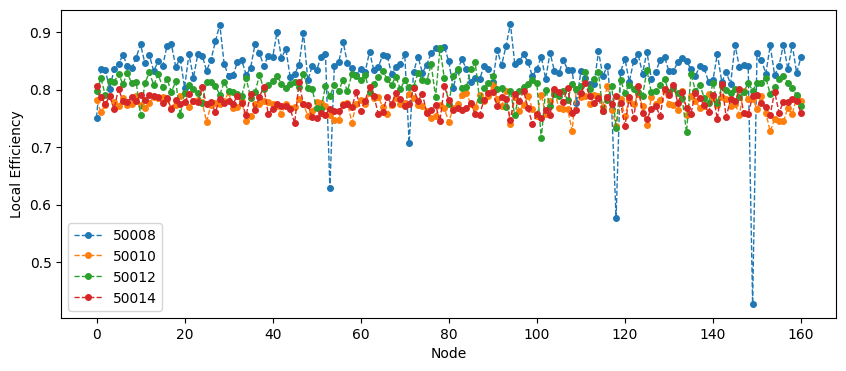

In [11]:
eff = []
for i, sub in enumerate(subjects):
    eff.append(graph.efficiency_bin(G[i], local=True))

eff = np.asarray(eff).T

plt.figure(figsize=(10,4))
plt.plot(eff, label=subjects, marker='o', markersize=4, linestyle='--', linewidth=1)
plt.xlabel('Node')
plt.ylabel('Local Efficiency')
plt.legend();

We can benchmark the performance of the local efficiency algorithm with the BCT implementation. It becomes apparent that the comet implementation is significantly faster, especially for large networks.

The following code block will run for 10-15 minutes, so maybe its preferrable to enjoy the graph instead of running it again :)

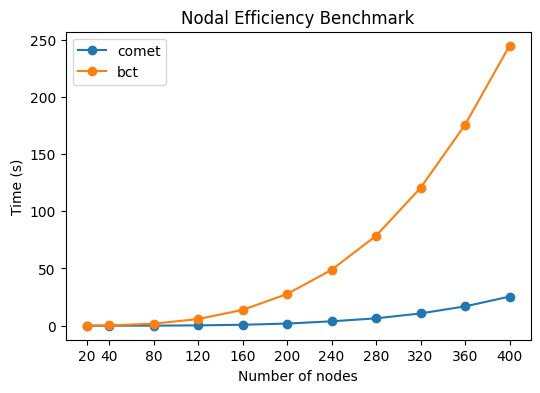

In [12]:
# Random graph with 400 nodes and 50% density
W = np.random.rand(400,400)
W = graph.symmetrise(W)
W = graph.threshold(W, type="density", density=0.5)

# Init methods at least once to avoid first-time overhead
init_comet = graph.efficiency_wei(W[:10,:10], local=True)
init_bct = bct.efficiency_wei(W[:10,:10])

# Run efficiency computation with increasing number of nodes
eff_comet = []
eff_bct = []
nodes = [20,40,80,120,160,200,240,280,320,360,400]
for i in nodes:
    start = time.time()
    eff = graph.efficiency_wei(W[:i,:i], local=True)
    eff_comet.append(time.time() - start)

    start = time.time()
    eff = bct.efficiency_wei(W[:i,:i], local=True)
    eff_bct.append(time.time() - start)

# Plot the results
plt.figure(figsize=(6,4))
plt.title('Nodal Efficiency Benchmark')
plt.plot(nodes, eff_comet, label="comet", marker='o')
plt.plot(nodes, eff_bct, label="bct", marker='o')
plt.xlabel('Number of nodes')
plt.xticks(nodes)
plt.ylabel('Time (s)')
plt.legend();

Matching index calculations are also significantly faster:

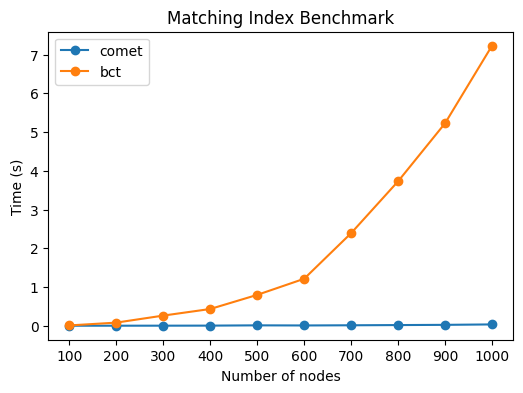

In [15]:
# Random graph with 400 nodes and 50% density
W = np.random.rand(1000,1000)
W = graph.symmetrise(W)
W = graph.threshold(W, type="density", density=0.5)

# Init methods at least once to avoid first-time overhead
init_comet = graph.matching_ind_und(W[:10,:10])
init_bct = bct.matching_ind_und(W[:10,:10])

# Run efficiency computation with increasing number of nodes
eff_comet = []
eff_bct = []
nodes = [100,200,300,400,500,600,700,800,900,1000]

for i in nodes:
    start = time.time()
    eff = graph.matching_ind_und(W[:i,:i])
    eff_comet.append(time.time() - start)

    start = time.time()
    eff = bct.matching_ind_und(W[:i,:i])
    eff_bct.append(time.time() - start)

# Plot the results
plt.figure(figsize=(6,4))
plt.title('Matching Index Benchmark')
plt.plot(nodes, eff_comet, label="comet", marker='o')
plt.plot(nodes, eff_bct, label="bct", marker='o')
plt.xlabel('Number of nodes')
plt.xticks(nodes)
plt.ylabel('Time (s)')
plt.legend();